In [61]:
from musicnet.preprocessing.wav_specs_and_notes.utils import create_tf_record_ds
from musicnet.utils import load_params, notes_vocab, instruments_vocab, Track, get_train_ids, BrokenMidiException
from multiprocessing import Pool
import pandas as pd
from matplotlib import pyplot as plt

In [62]:
def load_notes(id):
    track = Track(id)
    try:
        notes = track.get_norm_midi_notes()
    except BrokenMidiException:
        notes = pd.DataFrame()
    return notes

In [63]:
train_ids = get_train_ids()

In [64]:
with Pool(processes=8) as pool:
    track_notes = pool.map(load_notes, train_ids)

all_notes = pd.concat(track_notes, axis=0)

In [65]:
all_notes["duration"] = all_notes["end"] - all_notes["start"]

In [66]:
all_notes["duration"].to_numpy()

array([0.11805544, 0.11805544, 0.24305531, ..., 1.33333333, 2.17608367,
       0.66666667])

(array([ 6168.,  4895.,  5609.,  6779., 11964., 12959., 20479., 20478.,
        28960., 47737., 49327., 65291., 43702., 39632., 27527., 31793.,
        34504., 34476., 43945., 37496., 31940., 31193., 16331., 24669.,
        22420., 15030., 14043., 12954.,  9855., 11840., 13369., 10867.,
        13989.,  5967.,  5729.,  8872.,  5360., 14530.,  9318., 12782.,
         5594., 10205.,  8879.,  5980.,  4102.,  5322.,  4782.,  7478.,
         4178.,  5558.,  5185.,  3070.,  3911.,  3558.,  5506.,  2493.,
         3546.,  2063.,  4979.,  6185.,  3701.,  2462.,  2683.,  2142.,
          861.,  4692.,  2665.,   618.,  1298.,  2487.,  1033.,  2428.,
         1000.,  2790.,  4140.,  2295.,   934.,  1685.,  2366.,  3188.,
         1154.,  1535.,   902.,  2391.,   927.,  2130.,  1157.,  1348.,
         1173.,  1789.,  1972.,   958.,  1092.,   908.,   388.,  1195.,
          531.,  2024.,  1096.,  2789.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 

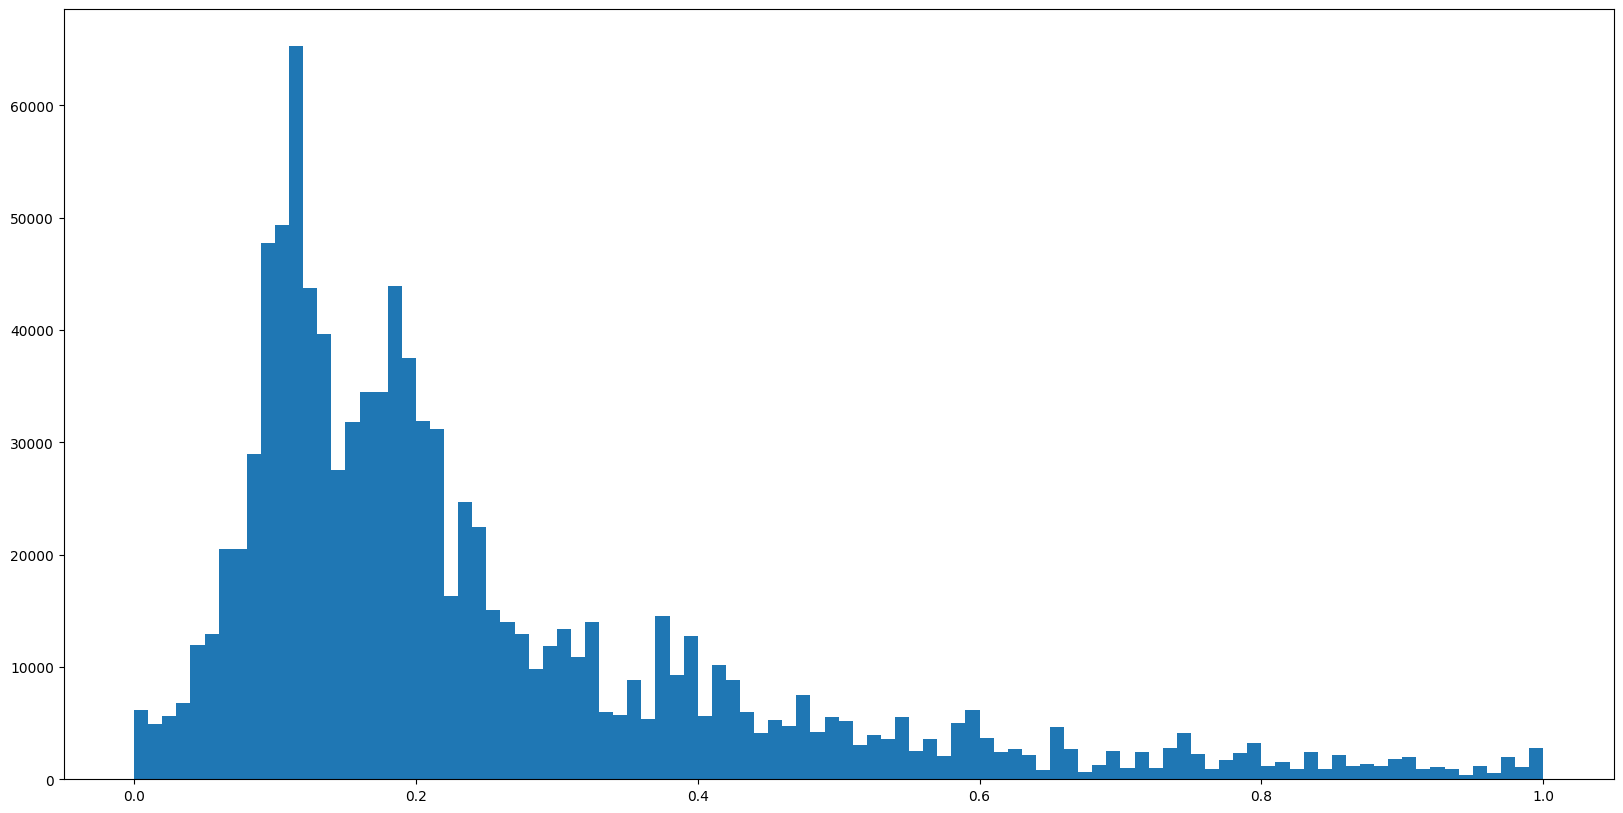

In [67]:
plt.figure(figsize=(20, 10))
plt.hist(all_notes["duration"].to_numpy(), range=[0, 1], bins=100)

In [68]:
100 * (all_notes["duration"] > 10).sum() / len(all_notes) 

0.006349340726787869

In [71]:
all_notes["duration"].min()

0.0

In [69]:
all_notes[all_notes["duration"] > 10]

,start,end,instrument,note,duration
607,142.758804,156.013085,1,32,13.254281
608,142.758804,156.013085,1,44,13.254281
3298,233.523147,252.502313,41,66,18.979167
4216,326.631662,339.628177,41,69,12.996515
4225,327.298328,340.314799,43,45,13.016471
...,...,...,...,...,...
2489,327.272700,354.465880,43,39,27.193180
3177,286.958117,297.178285,41,63,10.220168
136,39.174136,50.910099,1,47,11.735964
137,39.174136,50.910099,1,51,11.735964
